In [ ]:
# Use seaborn for pairplot
!pip install -q seaborn 

In [1]:
# from https://www.tensorflow.org/tutorials/keras/basic_regression
# more in https://www.youtube.com/watch?v=-vHQub0NXI4&t=175s

import tensorflow as tf
from tensorflow.keras import utils

print(tf.__version__)

dataset_path = utils.get_file("auto-mpg.data",
               "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

print(dataset_path)


1.14.1-dev20190307
/tmp/.keras/datasets/auto-mpg.data


In [2]:
import pandas as pd

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


In [3]:
print(dataset.isna().sum())

dataset = dataset.dropna()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [4]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0  


In [5]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

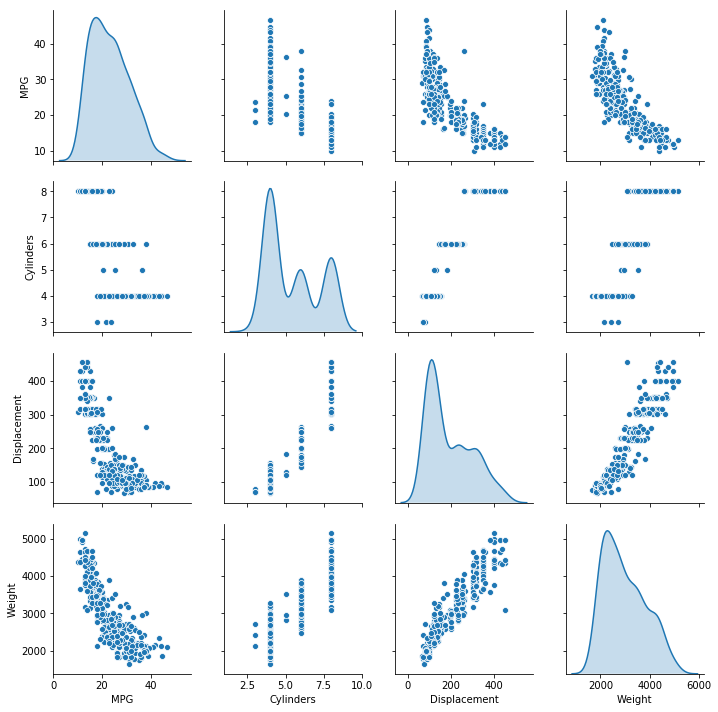

In [7]:
import seaborn as sns

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]],
             diag_kind="kde")

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)

              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

In [9]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import RMSprop

def build_model():
  model = Sequential()
  model.add(Dense(64, activation=relu, 
                    input_shape=[len(train_dataset.keys())]))
  model.add(Dense(64, activation=relu))
  model.add(Dense(1))

  model.compile(loss=mean_squared_error,
                optimizer=RMSprop(0.001),
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()
model.summary()


W0318 23:29:43.895878 140458785478400 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [12]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[-0.09021214]
 [ 0.10136068]
 [-0.16580835]
 [ 0.08065245]
 [ 0.53735375]
 [-0.05366552]
 [ 0.5948739 ]
 [ 0.5895219 ]
 [-0.16476426]
 [ 0.36753666]]


In [13]:
from tensorflow.keras.callbacks import Callback

# Display training progress by printing a single dot for each completed epoch
class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

epochs = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


.........

.............

...............

..............

...............

...............

...............

....
...........

..............

...............

................

..............

..............

................


..............

...............

...............

.............

...............

..............

..............


..............

..............

.............

..........

............

............

.............

............
.

...............

..............

..............

..............

..............

..............

..............
.

...............

...............

..............

................

...............

...............

.........
.....

..............

..............

..............

..............

...............

...............

.........
......

...............

...............

...............

...............

...............

..............

.....
..........

..............

..............

..............

..............

...............

...............

....
..........

............

...........

............

............

.............

.............

...............

..

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

         loss  mean_absolute_error  mean_squared_error  val_loss  \
995  1.917059             0.849795            1.917059  6.474944   
996  1.934832             0.880033            1.934832  7.100014   
997  1.830353             0.853845            1.830353  6.700199   
998  2.053787             0.917088            2.053787  6.549548   
999  1.933780             0.850164            1.933780  6.309664   

     val_mean_absolute_error  val_mean_squared_error  epoch  
995                 2.086542                6.474944    995  
996                 2.140734                7.100014    996  
997                 2.091969                6.700199    997  
998                 2.078990                6.549549    998  
999                 2.073601                6.309664    999  


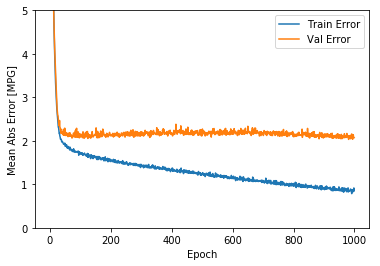

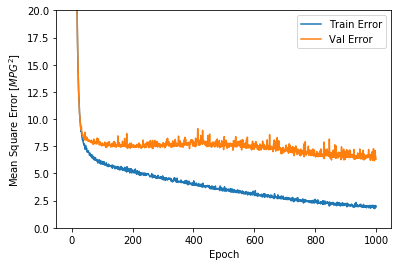

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.97 MPG



.........

..........

...........

.........

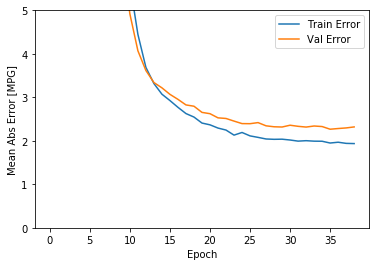

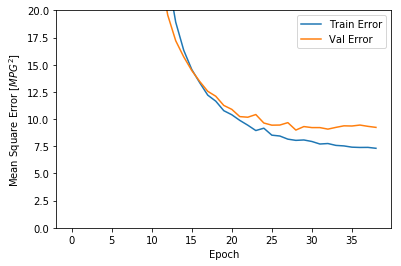

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 1000

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.95 MPG


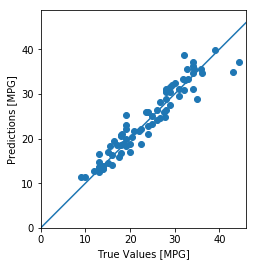

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

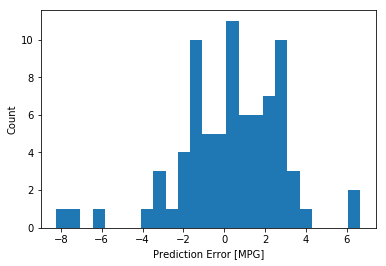

In [26]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")